- check unique - some columns with only 1 value
- check collinearity - can drop 200 columns from this
- try models with feature_importances: decision tree and MARS
    - stick with predictors with highest importances
- PCA after removing collinear predictors?
- tune models: RF, MARS, logreg (maybe), AdaBoost, XGBoost
- Ensemble
- Colab for RF GridSearch

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data
train = pd.read_csv('train.csv')
train.head()

,id,x001,x002,x003,x004,x005,x006,x007,x008,x009,...,x757,x758,x759,x760,x761,x762,x763,x764,x765,y
0,0,9.681860e+10,6991.15,7.76,0.00380,5.378811e+09,0.31,266117.20,934577.0,14539.0,...,0.0007,297281012,0.13,5.0,5,2.0,8.5127,14.28,-0.75,5
1,1,3.304810e+09,13914.43,5.37,0.00015,1.652405e+09,0.00,11927742.92,1798051.0,1051272.0,...,0.1136,3320000000000,0.08,661.0,0,350.0,1.5700,160.12,NaN,1
2,2,3.218944e+10,3991.98,5.77,0.00010,2.476111e+09,0.00,774385.01,375738.0,144143.0,...,0.0029,100474819,0.39,39.0,2,18.0,9.6800,25.06,-0.49,11
3,3,1.288000e+10,15937.45,5.86,0.00020,2.146667e+09,0.00,6324375.16,1932094.0,10055.0,...,0.0000,348000000000,0.25,2.0,1,0.0,4.5316,117.76,1.64,1
4,4,3.063412e+10,3621.00,7.52,0.00060,1.392460e+09,0.21,169860.29,474253.0,17914.0,...,0.0005,109546590,0.11,11.0,1,3.0,16.2717,5.81,-0.42,5


In [2]:
train.shape

(5380, 767)

In [3]:
# check how many observations have missing values
train_dropna = train.dropna()
train_dropna.shape

(2857, 767)

Removing NAs almost halved the dataset. Two options:
- continue as usual. performance will probably suffer.
- imputation:
    - mean
    - lin reg prediction imputation?
    - k-NN imputation

In [4]:
X = train.drop(['id', 'y'], axis=1)
y = train['y']
X.shape

(5380, 765)

In [5]:
# perform k-nn imputation on missing values
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
print(X_imputed.shape)
print(X_imputed.isna().sum().sum())
X_imputed.head()

(5380, 765)
0


,x001,x002,x003,x004,x005,x006,x007,x008,x009,x010,...,x756,x757,x758,x759,x760,x761,x762,x763,x764,x765
0,9.681860e+10,6991.15,7.76,0.00380,5.378811e+09,0.31,266117.20,934577.0,14539.0,2.690000e+13,...,1.5707,0.0007,2.972810e+08,0.13,5.0,5.0,2.0,8.5127,14.28,-0.75
1,3.304810e+09,13914.43,5.37,0.00015,1.652405e+09,0.00,11927742.92,1798051.0,1051272.0,1.690000e+17,...,0.1173,0.1136,3.320000e+12,0.08,661.0,0.0,350.0,1.5700,160.12,5.96
2,3.218944e+10,3991.98,5.77,0.00010,2.476111e+09,0.00,774385.01,375738.0,144143.0,1.350000e+14,...,0.4582,0.0029,1.004748e+08,0.39,39.0,2.0,18.0,9.6800,25.06,-0.49
3,1.288000e+10,15937.45,5.86,0.00020,2.146667e+09,0.00,6324375.16,1932094.0,10055.0,3.700000e+16,...,0.3816,0.0000,3.480000e+11,0.25,2.0,1.0,0.0,4.5316,117.76,1.64
4,3.063412e+10,3621.00,7.52,0.00060,1.392460e+09,0.21,169860.29,474253.0,17914.0,6.000000e+12,...,0.0100,0.0005,1.095466e+08,0.11,11.0,1.0,3.0,16.2717,5.81,-0.42


In [6]:
# identify variables with less than 8 unique values
cat_nonbin = []
for col in X_imputed.columns:
    if (len(X_imputed[col].unique()) < 8):
        print(col, '\n', X_imputed[col].unique())
        cat_nonbin.append(col)
print(len(cat_nonbin))

x025 
 [6. 2. 1. 5. 0. 3. 4.]
x063 
 [0.]
x137 
 [0.]
x255 
 [0.]
x385 
 [0.]
x405 
 [1.]
x453 
 [1.]
x465 
 [0.]
x516 
 [0. 1.]
x518 
 [0.]
x556 
 [1. 0.]
x594 
 [0.]
x643 
 [0.]
x703 
 [0.]
14


- 11 columns with only 1 value. Remove these since they cant be used for prediction if there is only 1 value among all instances.
- 2 binary and 1 categorical with 7 classes.

In [7]:
# redundant = ['x063', 'x137', 'x255', 'x385', 'x405', 'x453', 'x465', 'x518', 'x594', 'x643', 'x703']
redundant = []
for col in cat_nonbin:
    if (len(X_imputed[col].unique()) < 2):
        redundant.append(col)
len(redundant)

11

In [8]:
X_imputed.drop(redundant, axis=1, inplace=True)
X_imputed.shape

(5380, 754)

In [ ]:
# check which columns are not numeric
non_num = X_imputed.select_dtypes(exclude='number').columns
X_imputed[non_num].head()

In [ ]:
# convert non-numeric columns to numeric
X_imputed[non_num] = X_imputed[non_num].apply(pd.to_numeric, errors='coerce')

In [12]:
# check multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# the independent variables set
X = add_constant(X_imputed)

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
						for i in range(len(X.columns))]

print(vif_data.shape)
vif_data.head()

/Users/Albert/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


(755, 2)


,feature,VIF
0,const,0.000000
1,x001,3.777547
2,x002,0.475717
3,x003,0.023727
4,x004,1.193601


In [14]:
# get the features with VIF > 5
print(vif_data[vif_data['VIF'] > 5].shape)
vif_data[vif_data['VIF'] > 5]

(15, 2)


,feature,VIF
116,x117,4436.136771
179,x181,9.982747
187,x189,69.621759
191,x193,9.512693
203,x205,7.094817
236,x238,7.476384
263,x266,76.715819
317,x320,4326.394832
376,x379,2720.589900
402,x407,6.416722


In [15]:
# remove the features with VIF > 5
vif_features = vif_data[vif_data['VIF'] > 5]['feature'].values
vif_features = ['x117', 'x181', 'x189', 'x193', 'x205', 'x238', 'x266', 'x320', 'x379', 'x407',
 'x509', 'x667', 'x689', 'x700', 'x707']
print(vif_features)
X_imputed.drop(vif_features, axis=1, inplace=True)
X_imputed.shape

['x117' 'x181' 'x189' 'x193' 'x205' 'x238' 'x266' 'x320' 'x379' 'x407'
 'x509' 'x667' 'x689' 'x700' 'x707']


(5380, 739)

In [16]:
# perform PCA on the remaining features
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
train_pca = pca.fit_transform(X_imputed)
train_pca.shape

(5380, 2)

In [18]:
# train linear regression model with PCA features
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(train_pca, train['y'], test_size=0.2, random_state=42)
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
print('Test RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
# check train RMSE
y_pred_train = linreg.predict(X_train)
print('Train RMSE:', np.sqrt(mean_squared_error(y_train, y_pred_train)))

Test RMSE: 11.11049207014291
Train RMSE: 12.216774597268362


In [19]:
test = pd.read_csv('test.csv')
test.head()

,id,x001,x002,x003,x004,x005,x006,x007,x008,x009,...,x756,x757,x758,x759,x760,x761,x762,x763,x764,x765
0,5380,6.507826e+10,7882.15,6.82,0.00210,1.712586e+09,0.39,583617.74,862986.0,63872.0,...,0.0380,0.0010,90204869909,0.26,8.0,5,5.0,30.1213,27.95,-0.49
1,5381,3.122741e+09,4682.13,8.17,0.00010,1.040914e+09,0.00,190000.65,688710.0,35407.0,...,0.1866,0.0192,37449565014,0.02,16.0,1,8.0,2.1282,10.18,0.55
2,5382,3.888719e+10,7495.57,7.15,0.00285,2.160400e+09,0.42,351570.67,841523.0,170240.0,...,0.0100,0.0017,10847937619,0.83,35.0,1,19.0,7.8513,21.27,19.09
3,5383,7.727427e+10,4003.76,6.53,0.00165,5.519591e+09,0.00,320216.05,466131.0,35.0,...,0.4636,0.0000,37200096,0.51,1.0,4,0.0,9.0511,18.38,4.11
4,5384,4.184868e+09,34874.72,6.39,0.00065,1.046217e+09,0.50,3349978.53,3711028.0,1757.0,...,2.8737,0.0001,16400000000000,0.12,2.0,1,2.0,2.6512,149.68,0.02


In [21]:
id = test['id']
test.drop(['id'], axis=1, inplace=True)
test_imputed = pd.DataFrame(imputer.transform(test), columns=test.columns)
print(test_imputed.shape)
print(test_imputed.isna().sum().sum())
test_imputed.head()

(4403, 765)
0


,x001,x002,x003,x004,x005,x006,x007,x008,x009,x010,...,x756,x757,x758,x759,x760,x761,x762,x763,x764,x765
0,6.507826e+10,7882.15,6.82,0.00210,1.712586e+09,0.39,583617.74,862986.0,63872.0,1.470000e+14,...,0.0380,0.0010,9.020487e+10,0.26,8.0,5.0,5.0,30.1213,27.95,-0.49
1,3.122741e+09,4682.13,8.17,0.00010,1.040914e+09,0.00,190000.65,688710.0,35407.0,1.130000e+13,...,0.1866,0.0192,3.744957e+10,0.02,16.0,1.0,8.0,2.1282,10.18,0.55
2,3.888719e+10,7495.57,7.15,0.00285,2.160400e+09,0.42,351570.67,841523.0,170240.0,4.140000e+13,...,0.0100,0.0017,1.084794e+10,0.83,35.0,1.0,19.0,7.8513,21.27,19.09
3,7.727427e+10,4003.76,6.53,0.00165,5.519591e+09,0.00,320216.05,466131.0,35.0,2.080000e+13,...,0.4636,0.0000,3.720010e+07,0.51,1.0,4.0,0.0,9.0511,18.38,4.11
4,4.184868e+09,34874.72,6.39,0.00065,1.046217e+09,0.50,3349978.53,3711028.0,1757.0,2.110000e+16,...,2.8737,0.0001,1.640000e+13,0.12,2.0,1.0,2.0,2.6512,149.68,0.02


In [22]:
# drop redundant and multicollinear features
test_imputed.drop(redundant, axis=1, inplace=True)
test_imputed.drop(vif_features, axis=1, inplace=True)
test_imputed.shape

(4403, 739)

In [23]:
# pca on test data
test_pca = pca.transform(test_imputed)
test_pca.shape

(4403, 2)

In [24]:
# predict on test data
y_pred_test = linreg.predict(test_pca)
y_pred_test

array([8.76397649, 8.76397623, 8.76397665, ..., 8.76397332, 8.76334354,
       8.7160544 ])

In [25]:
# preds dataframe
preds = pd.DataFrame({'id': id, 'y': y_pred_test})
preds.head()

,id,y
0,5380,8.763976
1,5381,8.763976
2,5382,8.763977
3,5383,8.763977
4,5384,8.763015


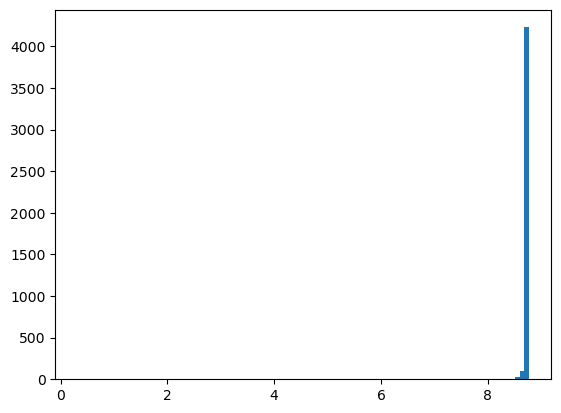

In [26]:
# distribution of predictions
plt.hist(preds['y'], bins=100)
plt.show()

In [27]:
preds.to_csv('preds.csv', index=False)